[LightGBM] [Info] Number of positive: 286, number of negative: 6714
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6326
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.040857 -> initscore=-3.155958
[LightGBM] [Info] Start training from score -3.155958


c:\Users\palak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\palak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Binary Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2878
           1       0.50      0.01      0.02       122

    accuracy                           0.96      3000
   macro avg       0.73      0.50      0.50      3000
weighted avg       0.94      0.96      0.94      3000

ROC-AUC: 0.6904926007359391


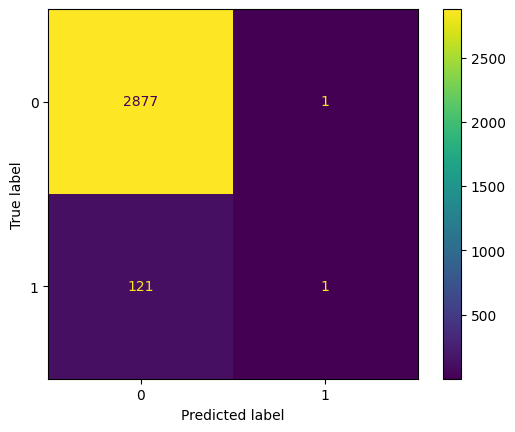

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6327
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 67
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -0.798508
[LightGBM] [Info] Start training from score -1.049822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\palak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


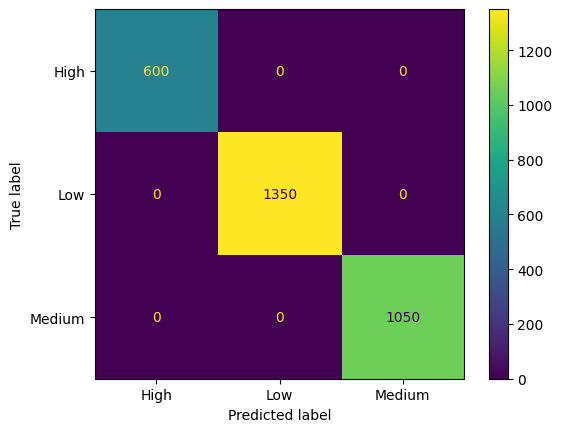

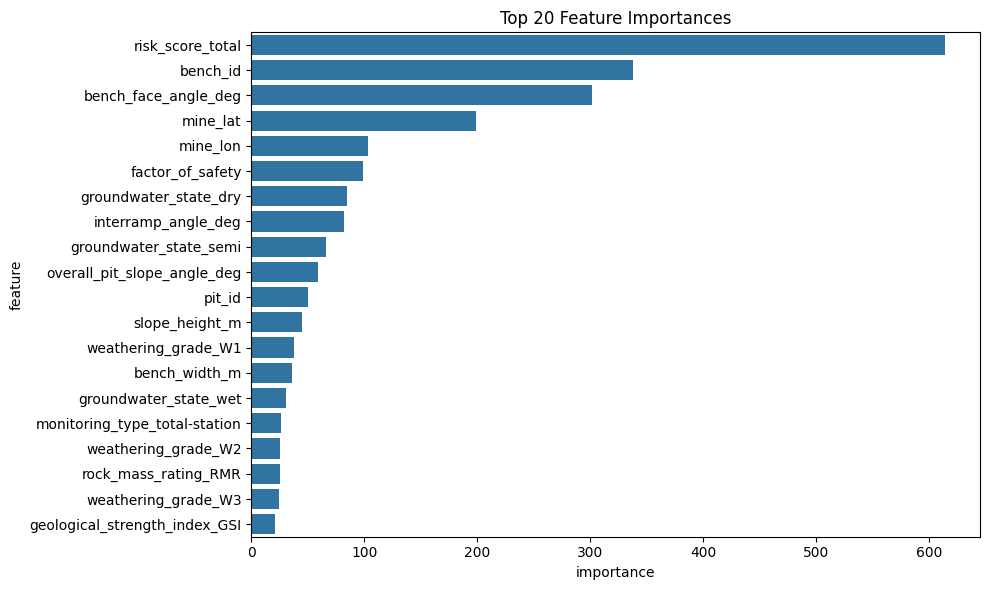

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
import joblib

# Load data
df = pd.read_csv("C:\\Users\\palak\\AI-Based-Rockfall-Prediction-System\\Backend\\data\\rockfall_dataset_10k_BALANCED.csv")

target_binary = "rockfall_event_within_7d"
target_multi = "risk_class"

drop_cols = ["record_id","timestamp","mine_site","state","commodity",
             "risk_class","rockfall_event_within_7d"]
features = [c for c in df.columns if c not in drop_cols]

X = df[features]
y_bin = df[target_binary]
y_multi = df[target_multi]

cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

preproc = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])

# Binary classification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.3, stratify=y_bin, random_state=42
)

pipe_bin = Pipeline([
    ("preproc", preproc),
    ("clf", LGBMClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1))
])

pipe_bin.fit(X_train, y_train)
y_pred_bin = pipe_bin.predict(X_test)
y_prob_bin = pipe_bin.predict_proba(X_test)[:,1]

print("Binary Classification Report:")
print(classification_report(y_test, y_pred_bin))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_bin))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_bin)
plt.show()

# Save binary model
joblib.dump(pipe_bin, "rockfall_model_lgbm_bin.pkl")

# Multi-class classification
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X, y_multi, test_size=0.3, stratify=y_multi, random_state=42
)

pipe_multi = Pipeline([
    ("preproc", preproc),
    ("clf", LGBMClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1))
])

pipe_multi.fit(X_train_m, y_train_m)
y_pred_multi = pipe_multi.predict(X_test_m)

print("Multi-Class Classification Report:")
print(classification_report(y_test_m, y_pred_multi))

ConfusionMatrixDisplay.from_predictions(y_test_m, y_pred_multi)
plt.show()

# Save multi-class model
joblib.dump(pipe_multi, "rockfall_model_lgbm_multi.pkl")

# Feature importance (multi-class)
encoder = pipe_multi.named_steps["preproc"].named_transformers_["cat"]
cat_names = encoder.get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([cat_names, num_cols])

importances = pipe_multi.named_steps["clf"].feature_importances_
feat_imp = pd.DataFrame({"feature": all_feature_names, "importance": importances})
feat_imp = feat_imp.sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=feat_imp)
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()